# Postmodel Analysis

This notebook will guide the `triage` user through some useful rutines to compare individual models across `model_group_id`'s. This is an interactive process that combines huntches and some general ways to compare 
models. Before starting this process, is important to run `triage`'s _Audition_ component which will filter
`model_group_id`'s using user-defined metrics (see [Audition](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb) to explore more). 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import OrderedDict
from utils.aux_funcs import *
from triage.component.catwalk.storage import ProjectStorage, ModelStorageEngine, MatrixStorageEngine
from parameters import PostmodelParameters
from model_evaluator import ModelEvaluator
from model_group_evaluator import ModelGroupEvaluator

/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Parameters

Postmodel need a set of parameters to pass through some of its functions. This will allow the user to better analyize its models, some of this parameters can be readed from a `rules.yaml` file, or any `.yaml` file passed to the `Audition` component. Also, you can use a `postmodeling_parameters.yaml` if you want to set other paramters, or pass your own parameters by defnining them in this notebook. 

This parameters include: 
 - `model_group_id`: List with selected `ModelGroup` from `Audition`
 - `metric`: Selected metric string (i.e. `precision`,`recal`)
 - `parameter`: Selected threshold string (i.e. `50_abs`, `5.0_pct`)
 - `top_n`: Absolute number (int) threshold, if parameter not defined
 - `n_features`: Number of features to calculate feature importances (int)
 - `max_depth`: For residual decision trees, number of splits (int)
 - `feature_groups`: List of feature groups

Some aesthetic parameters

 - `figsize`: Plot size (tuple)
 - `fontsize`: Font size for plots (int)

In [2]:
params = PostmodelParameters('postmodeling_config.yaml')

These are the parameters stored in the `postmodeling_config.yaml`, and the notebook will use this to set parameters in other functions

In [3]:
params.__dict__

{'project_path': '../../../../../../triage_output/output/',
 'model_group_id': [19, 43, 55],
 'thresholds': {'rank_abs': [10, 20, 50], 'rank_pct': [10, 20, 50]},
 'baseline_query': "SELECT g.model_group_id,\n       m.model_id,\n       EXTRACT('YEAR' FROM m.evaluation_end_time) AS as_of_date_year,\n       m.metric,\n       m.parameter,\n       m.value,\n       m.num_labeled_examples,\n       m.num_labeled_above_threshold,\n       m.num_positive_labels\n FROM test_results.evaluations m\n LEFT JOIN model_metadata.models g\n USING(model_id)\n WHERE g.model_group_id IN (1)\n",
 'max_depth_error_tree': 5,
 'n_features_plots': 10,
 'figsize': (12, 12),
 'fontsize': 20,
 'thresholds_iterator': {'rank_abs': [10, 20, 50], 'rank_pct': [10, 20, 50]}}

### 1. Load audited model groups in a list
Audition will output a dict object with a set of models for each of the defined metrics. We can either read from Audition output, or we can define a list (`audited_models`) to start the post-modeling exploration. We will get each individual `model_id` from the audited `model_groups_id`'s and get the relevant metadata and matrices for each models using the `Model` class. 

In [4]:
# List the audited model groups
audited_models_groups = params.model_group_id

# Get models_ids tuples from selected model_group_ids
list_tuple_models = get_models_ids(audited_models_groups, conn)

# Use Model class object and retrieve indiviual model metadata
l_t = [ModelEvaluator(i.model_group_id, i.model_id) for i in list_tuple_models]

We can explore each of the model class attributes:

In [5]:
l_t[0].__dict__

{'model_id': 44,
 'model_group_id': 19,
 'model_type': 'sklearn.ensemble.RandomForestClassifier',
 'hyperparameters': {'criterion': 'gini',
  'class_weight': 'balanced',
  'max_features': 'sqrt',
  'n_estimators': 1000,
  'min_samples_leaf': 1,
  'min_samples_split': 50},
 'model_hash': '24b5b54afdfd61cf89b10d02b5c5e31d',
 'train_matrix_uuid': '936d9a0559092efbde15043d36b557a0',
 'pred_matrix_uuid': '8a2f41920a5b27466c278751f7643b50',
 'as_of_date': Timestamp('2016-01-13 00:00:00')}

Or we can explore all our models:

In [6]:
model_df = pd.DataFrame([model.__dict__ for model in l_t])
model_df = model_df.loc[:, ['model_group_id', 'model_id', 'as_of_date','model_type', 'hyperparameters', 'train_matrix_uuid']].sort_values(['model_group_id'])
pd.concat([model_df.drop(['hyperparameters'], axis=1), model_df['hyperparameters'].apply(pd.Series)], axis=1)

,model_group_id,model_id,as_of_date,model_type,train_matrix_uuid,criterion,class_weight,max_features,n_estimators,min_samples_leaf,min_samples_split
0,19,44,2016-01-13,sklearn.ensemble.RandomForestClassifier,936d9a0559092efbde15043d36b557a0,gini,balanced,sqrt,1000,1,50
3,19,86,2017-01-13,sklearn.ensemble.RandomForestClassifier,d1abe0f61726575979c2194390af8ba3,gini,balanced,sqrt,1000,1,50
6,19,128,2018-01-13,sklearn.ensemble.RandomForestClassifier,02a250d1df77a98b8979bdfb656d029a,gini,balanced,sqrt,1000,1,50
1,43,68,2016-01-13,sklearn.ensemble.RandomForestClassifier,a4310fc069672a3df46a618d2acd8c43,gini,balanced,sqrt,1000,1,50
4,43,110,2017-01-13,sklearn.ensemble.RandomForestClassifier,c7450a6c72ff1b067a5d30e78b47c080,gini,balanced,sqrt,1000,1,50
7,43,152,2018-01-13,sklearn.ensemble.RandomForestClassifier,4b09c67e31e6a0cba9f99aef600967c2,gini,balanced,sqrt,1000,1,50
2,55,80,2016-01-13,sklearn.ensemble.RandomForestClassifier,27064e1288bbd8d0fd712af48269364a,gini,balanced,sqrt,1000,1,50
5,55,122,2017-01-13,sklearn.ensemble.RandomForestClassifier,e9280b7305e1eb070484dcb8c88a0ee2,gini,balanced,sqrt,1000,1,50
8,55,164,2018-01-13,sklearn.ensemble.RandomForestClassifier,74faccd22f6762218a0a432dec469a79,gini,balanced,sqrt,1000,1,50


Some of the attributes are defined as `None` by default due to memory and efficiency constraints. To load _heavy_ matrices and predictions we have different methods to do so. The `load_features_preds_matrix` and `load_train_matix` methods are helpful options that will retrieve matrices from either AWS S3 or local files (depending on the `path` argument, the function will use the rigth approach). 

## 2. Individual model exploration

We can split the model exploration in several steps: 
   1. Predicted labels distribution
   2. Features importances
   3. Model Metrics
   4. Error Trees

### 1. Score/Label Distributions

We can first give a intuitive description of the classification by ploting how the score distributes across the predicted labels. You can change some attributes of the plots: 
 - `figsize`: changes the object size passed to matplotlib
 - `fontsize`: changes the fontsize passed to axes, legends and title
 - `label_names`: changes the label arguments.
 
Check the Method definition for more options

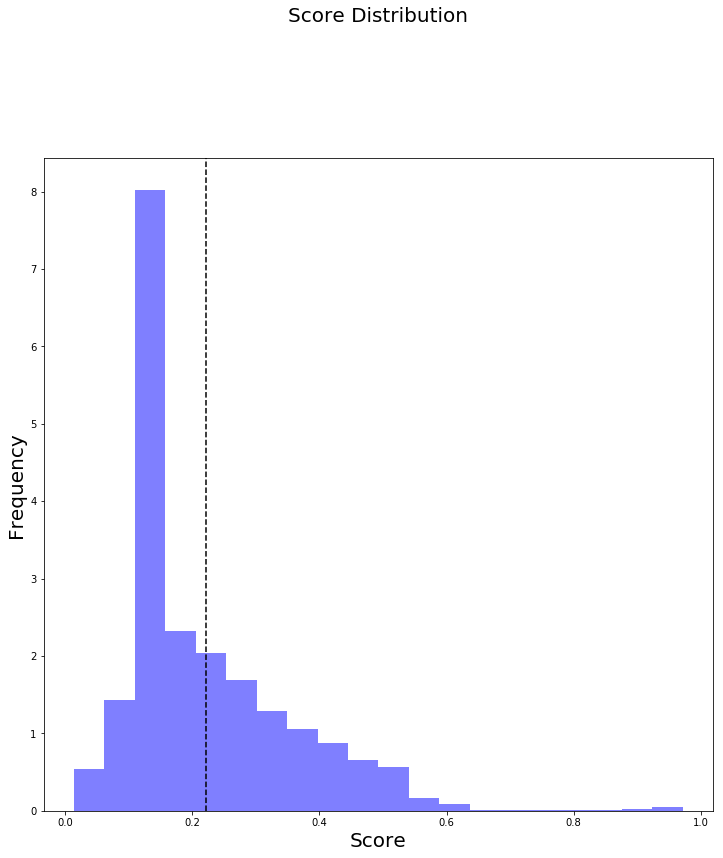

In [11]:
l_t[1].plot_score_distribution(figsize=params.figsize)

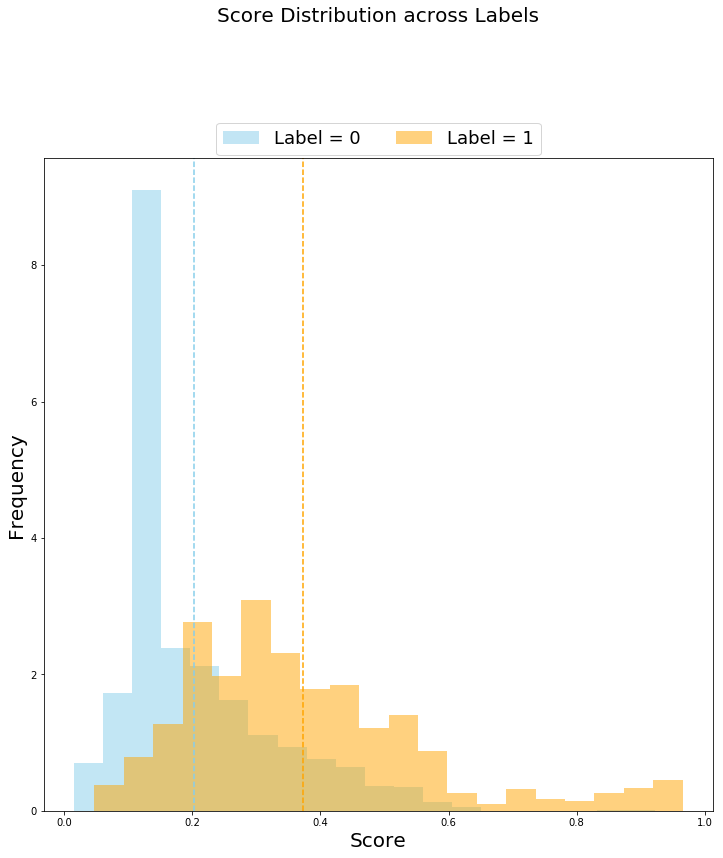

In [24]:
l_t[0].plot_score_label_distributions(figsize=params.figsize)

We can check the score behavior across a specific feature (loading the prediction matrix first)

#### 2. Features importances

We can extract individual feature importances from `triage` results schema and indentify the important features for each model. In this `dirtyduck` example, we find that the feature score for importance has a bi-modal behavior, which persists even when removing the features with 0 importance value. 


We can also plot the top-10 features by importance

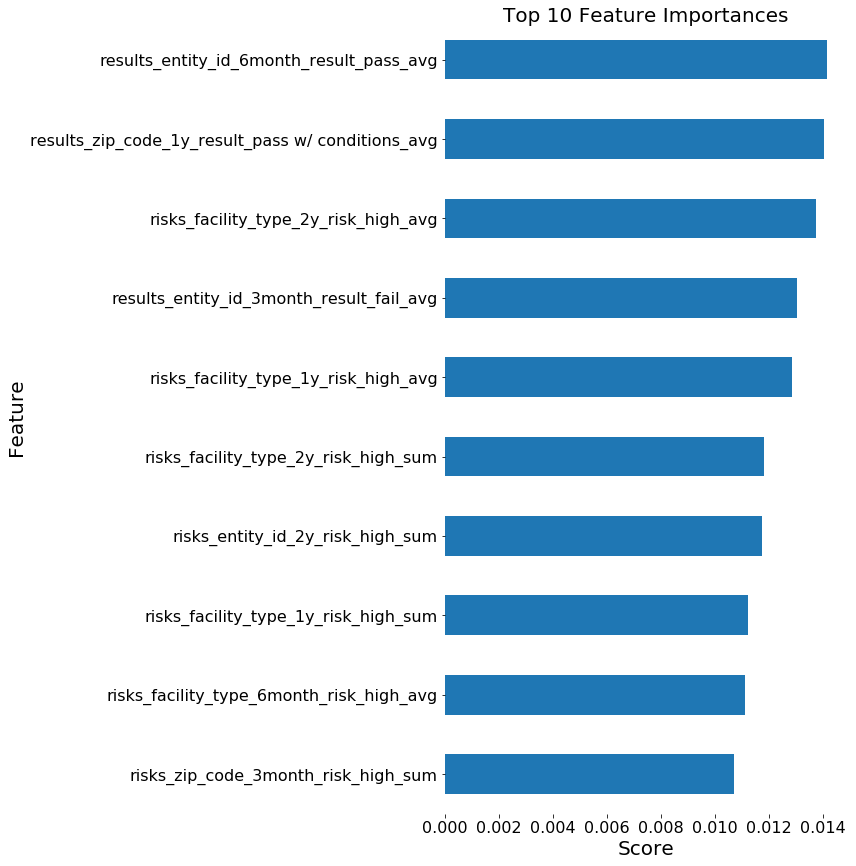

In [25]:
l_t[0].plot_feature_importances(n_features_plots=params.n_features_plots, figsize=params.figsize)

### Feature importances with sd

/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


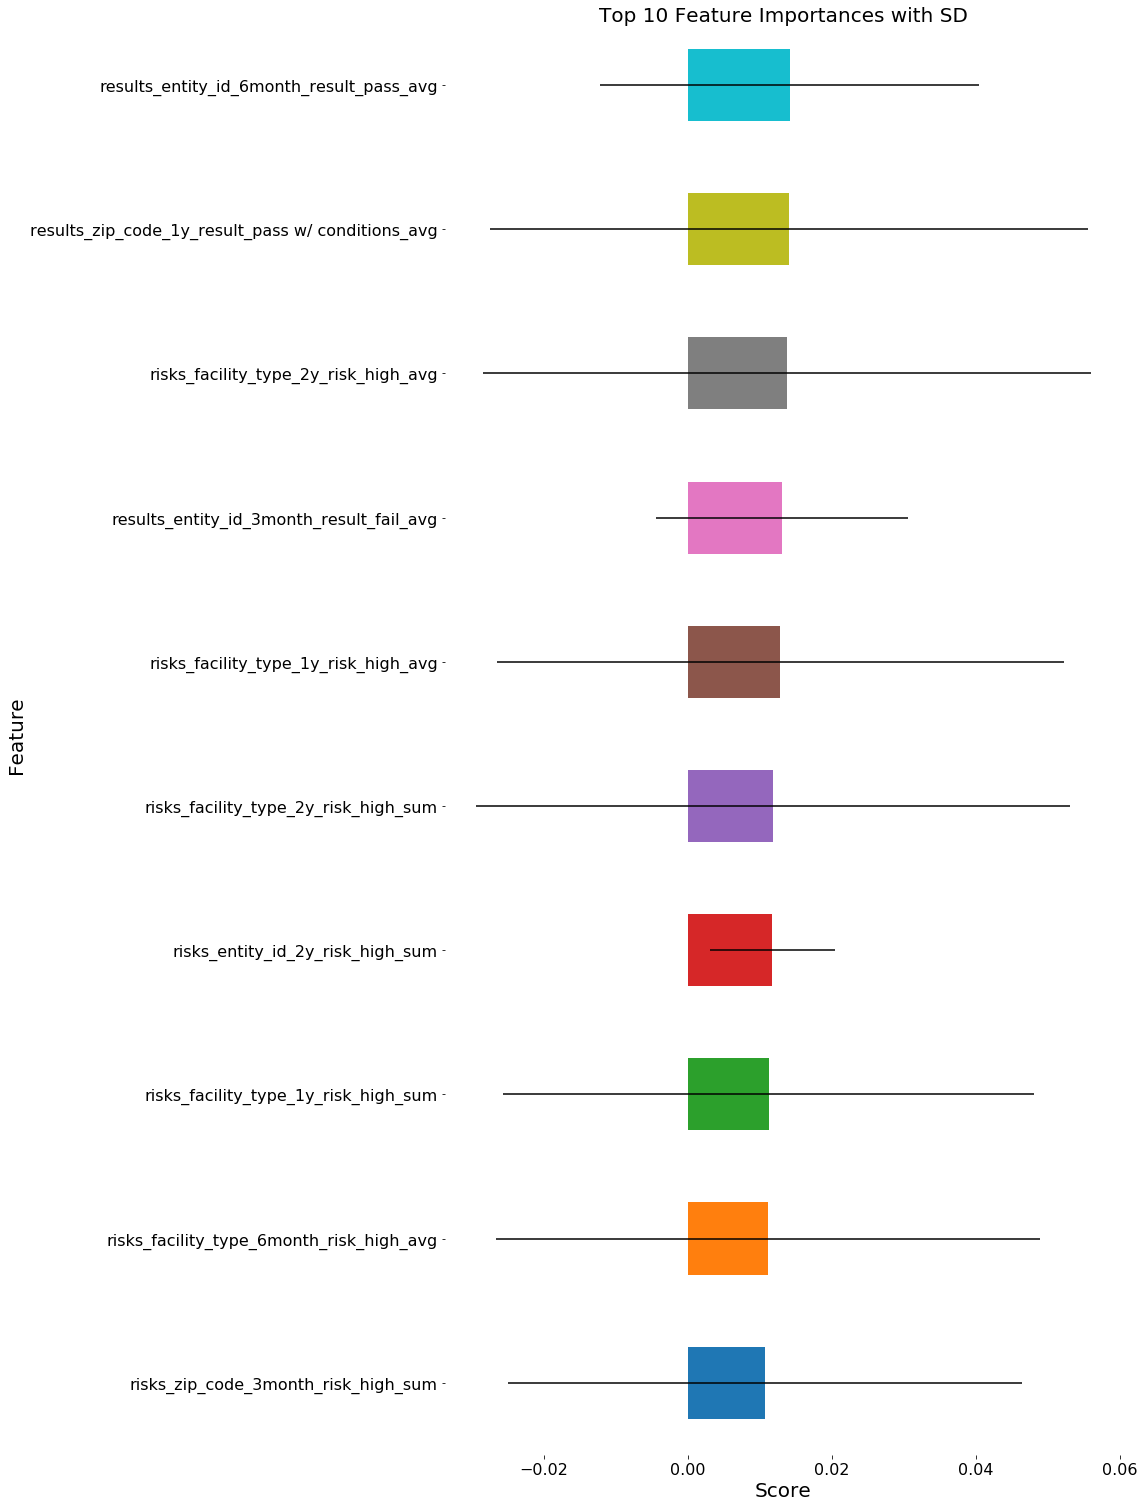

In [26]:
l_t[0].plot_feature_importances_std_err(path= params.project_path, 
                                        n_features_plots = params.n_features_plots)

### 3. Model Metrics

The `Model` class include some handy methods/wrappers to plot `sklearn` metrics to assess some common model metrics: AUC, ROC Curves, Precision vs. Recall, and others: 

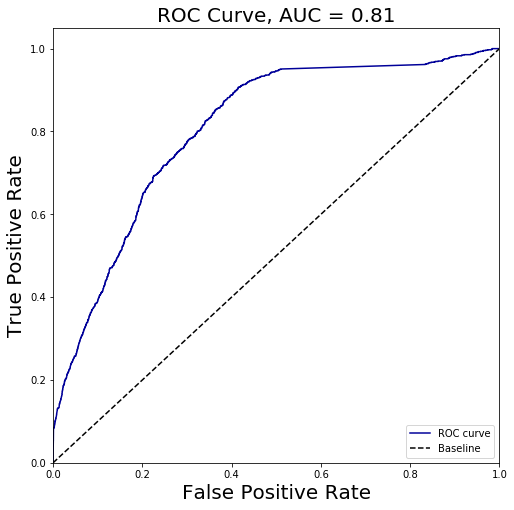

In [27]:
l_t[0].plot_ROC(figsize=(8,8))

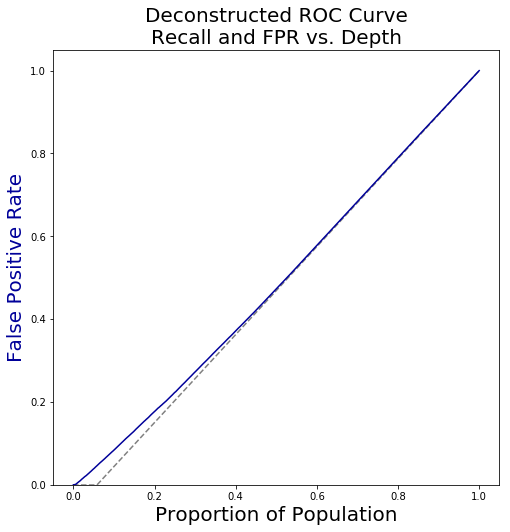

In [28]:
l_t[0].plot_recall_fpr_n(figsize=(8,8))

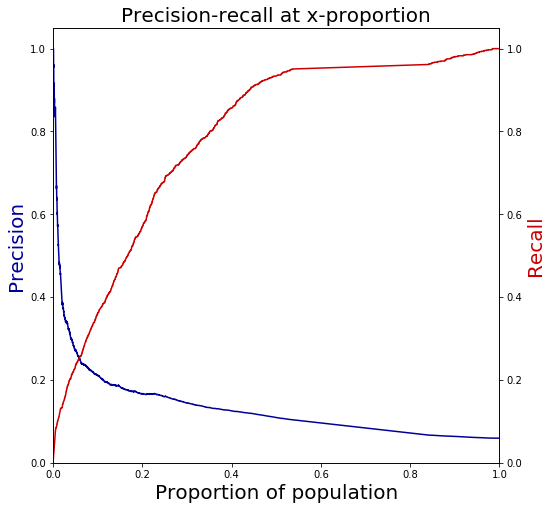

In [29]:
l_t[0].plot_precision_recall_n(figsize=(8,8))

### 4. Error Trees

One way to explore which feature is altering (or has a high leverage) the predictions of the model is by unveiling the patters of the residuals. We can do this by implementing a decision tree that use the residuals: $ \hat y_{t+1} - y_{t}$ as input and get the features that have a bigger relevance. 

In [15]:
l_t[0].error_analysis(params.thresholds_iterator,
                      depth=params.max_depth_error_tree,
                      path=params.project_path,
                      view_plots=False)

rank_abs 10
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_abs', 'param': 10}
error_analysis_FPR_44_rank_abs@10.gv
error_analysis_FNR_44_rank_abs@10.gv
rank_abs 20
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_abs', 'param': 20}
error_analysis_FPR_44_rank_abs@20.gv
error_analysis_FNR_44_rank_abs@20.gv
rank_abs 50
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_abs', 'param': 50}
error_analysis_FPR_44_rank_abs@50.gv
error_analysis_FNR_44_rank_abs@50.gv
rank_pct 10
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_pct', 'param': 10}
error_analysis_FPR_44_rank_pct@10.gv
error_analysis_FNR_44_rank_pct@10.gv
rank_pct 20
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_pct', 'param': 20}
error_analysis_FPR_44_rank_pct@20.gv
error_analysis_FNR_44_rank_pct@20.gv
rank_pct 50
{'path': '../../../../../../triage_output/output/', 'param_type': 'rank_pct', 'param': 50}
error_analys

### Crosstabs

Crosstabs is already on development, you can [check out it](https://github.com/dssg/postmodel-analysis/tree/sqlqueries/postmodel/crosstabs). `crosstabs` will generate a table with the differences in feature distributions across predicted entites using a top-k precision. 

In [6]:
a = l_t[0].crosstabs
a_ratio = a.loc[a.metric == 'ratio_predicted_positive_over_predicted_negative',:]
a_sorted = a_ratio.sort_values(by=['value'], ascending=False)[:params.n_features_plots]
a_sorted

,model_id,as_of_date,metric,feature_column,value,threshold_unit,threshold_value
168,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60634,18.140645,abs,50
231,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60626,11.026667,abs,50
2349,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60634,9.127805,abs,50
867,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60610,8.179782,abs,50
1241,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,inspections_entity_id_3month_type_canvass_avg,7.891676,abs,50
1879,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60610,6.879412,abs,50
1232,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,inspections_entity_id_3month_type_canvass_sum,6.394996,abs,50
204,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60630,6.318652,abs,50
2906,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,inspections_entity_id_3month_type_complaint_avg,6.256257,abs,50
373,44,2016-01-13 06:00:00+00:00,ratio_predicted_positive_over_predicted_negative,zip_code_60605,5.680404,abs,50


## 3. Model Group Exploration (and across all models)

We can define a `ModelGroup` class object where we store all the data for all the selected models and make comparisons easier. We have some basic methods that can serve us to compare methods. This works as a batch of individual `model_id` and we can compare between them.

TO-DO:
 - Spearman correlation: for features and top-k entities

In [4]:
audited_models_class = ModelGroupEvaluator(tuple(params.model_group_id))

Precision across time :) 

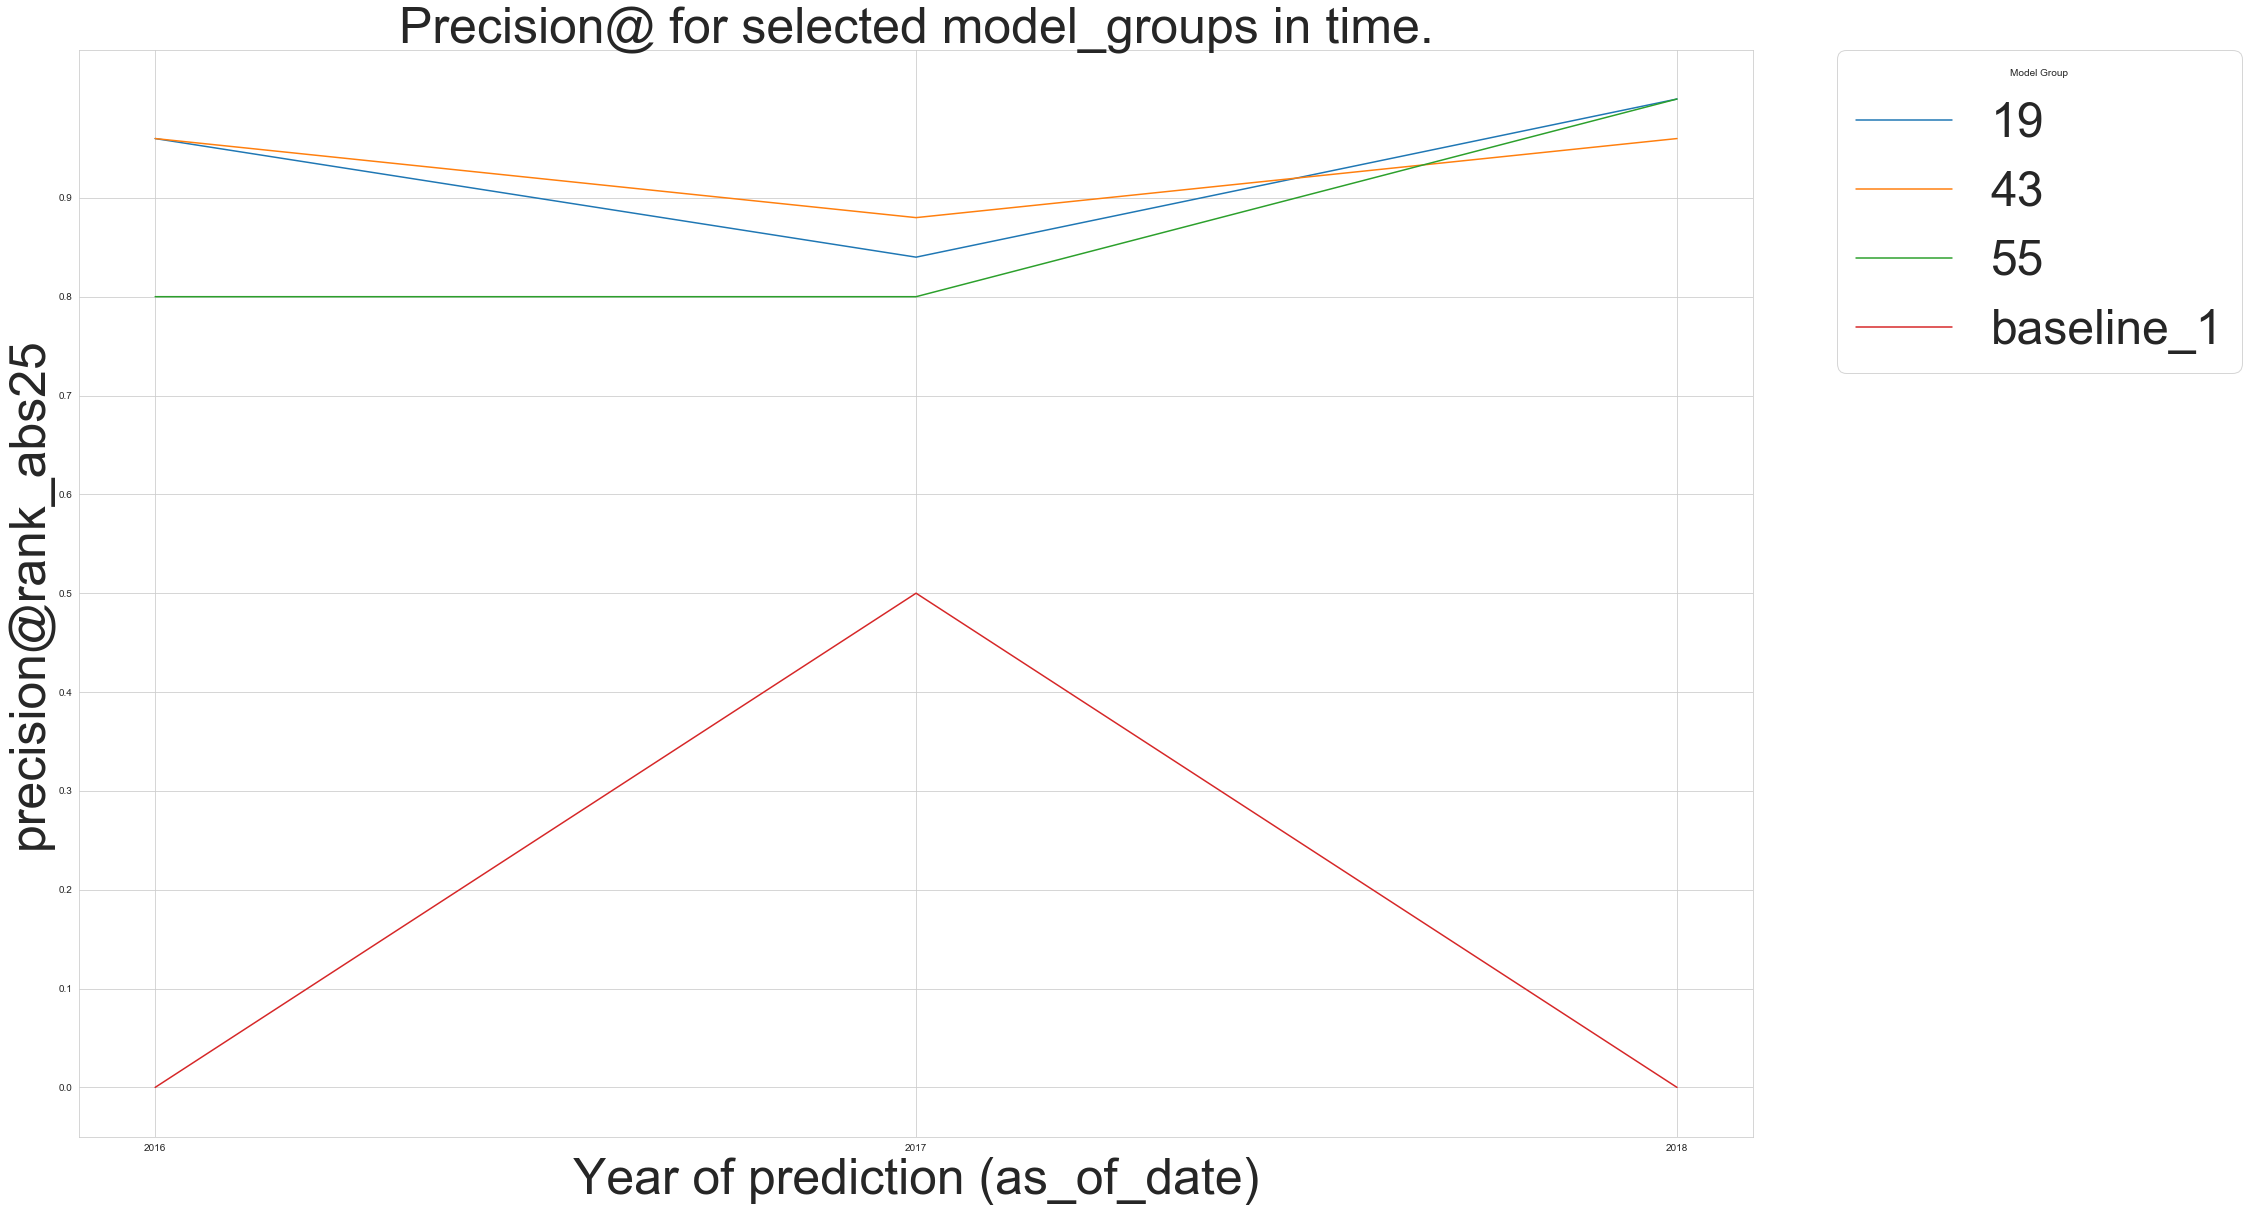

In [10]:
audited_models_class.plot_prec_across_time(param_type='rank_abs',
                                           param=25,
                                           baseline=True,
                                           baseline_query=params.baseline_query,
                                           metric='precision@',
                                           figsize=(30,20),
                                           fontsize=50)

We can check the contents of the `ModelGroup` class.

In [57]:
set(metrics_model['model_group_id'].tolist())

{19, 43, 55}

In [5]:
print(audited_models_class)

Model collection object for model_ids:[152, 80, 44, 68, 122, 110, 164, 86, 128]
Model Groups: (19, 43, 55)
Model types: ['sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier']
Model hyperparameters: [{'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_weig

Since each `model_id` has different temporal configurations, we can explore the prediction window for each of the models and identify the models that have the same temporal configuration. 

In [6]:
model_group_df = pd.DataFrame({'model_id': audited_models_class.model_id,
                              'as_of_date': audited_models_class.train_end_time})
model_group_df.sort_values('as_of_date', ascending=False)

,model_id,as_of_date
0,152,2018-01-13
6,164,2018-01-13
8,128,2018-01-13
4,122,2017-01-13
5,110,2017-01-13
7,86,2017-01-13
1,80,2016-01-13
2,44,2016-01-13
3,68,2016-01-13


### 2. Jaccard Similarity
We can compare models using the overlap between entity predictions for each `as_of_date`.

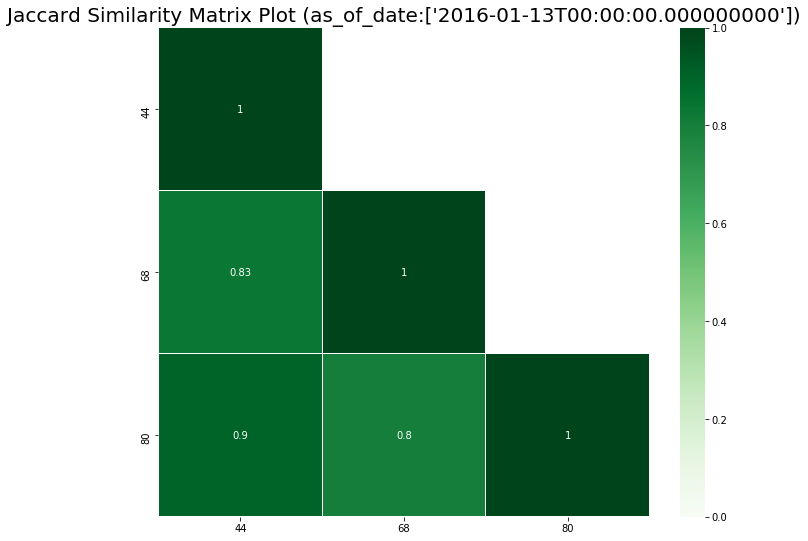

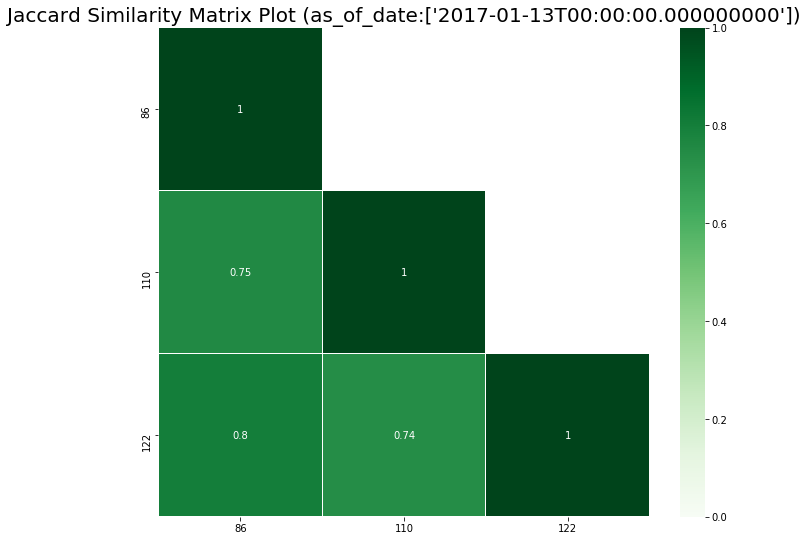

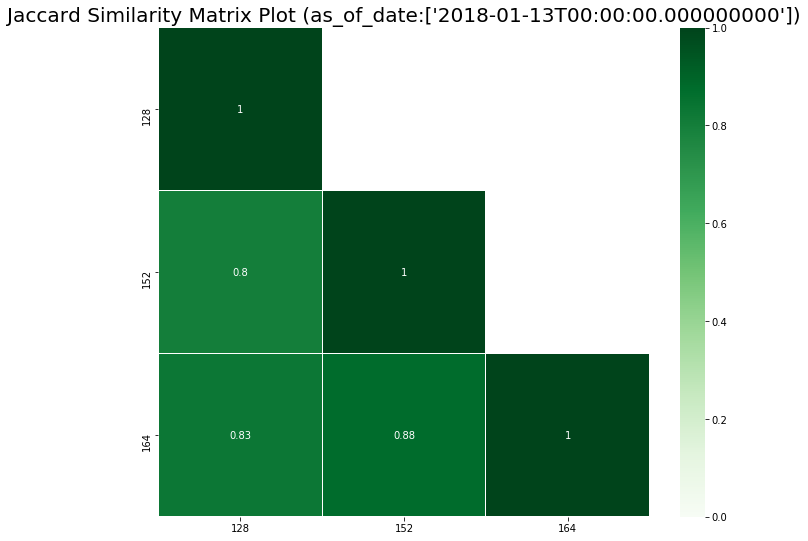

In [13]:
audited_models_class.plot_jaccard(figsize=param.figsize, 
                                  top_n= 100)

Although, we can compare the selection of each model for each predicted `as_of_date` using the overall

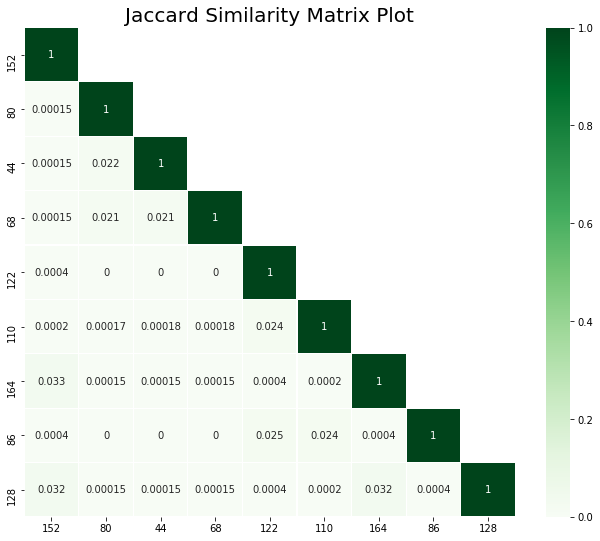

In [15]:
audited_models_class.plot_jaccard(figsize=(11,9), top_n = 100, temporal_comparison=False)

### 2. Rank Comparison

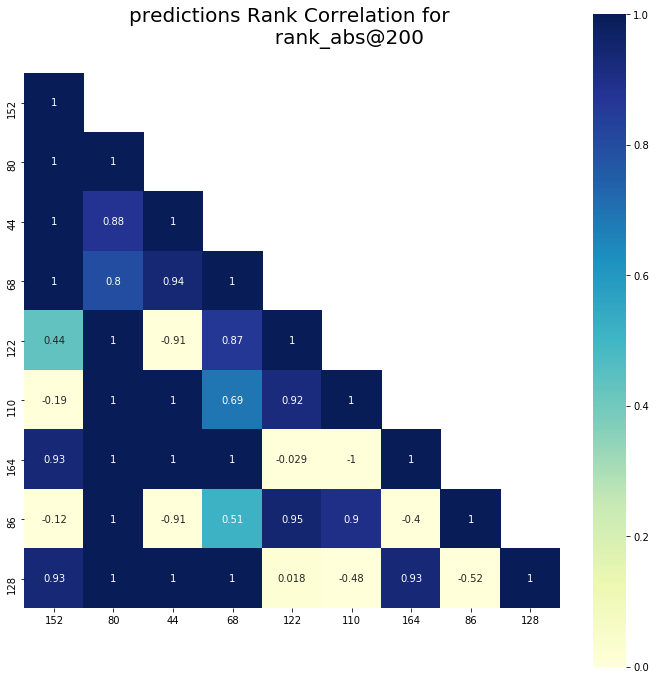

In [32]:
audited_models_class.plot_ranked_corrlelation(figsize=params.figsize,
                                               corr_type='predictions',
                                               param_type='rank_abs',
                                               param=200)

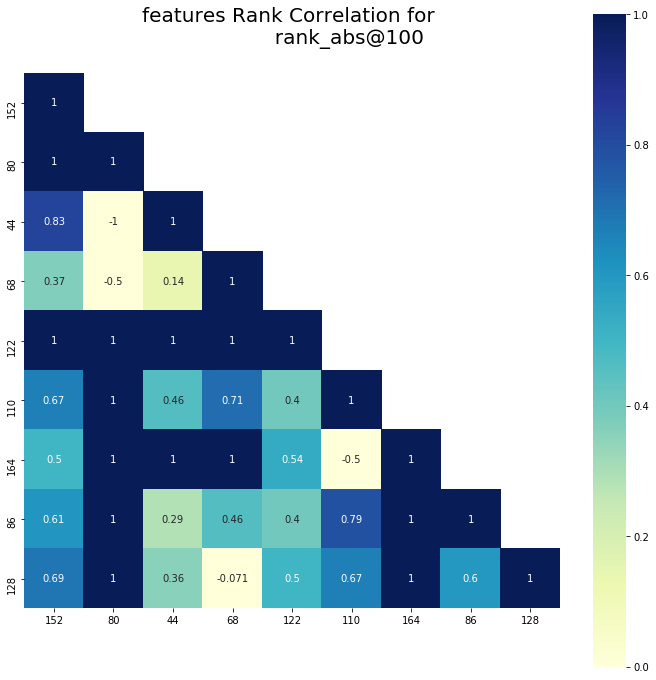

In [10]:
audited_models_class.plot_ranked_corrlelation(figsize=params.figsize,
                                               corr_type='features',
                                               param_type='rank_abs',
                                               param=100,
                                               top_n_features=params.n_features_plots)